In [1]:
import numpy as np
from numpy.linalg import multi_dot
from numpy.linalg import qr
import numpy.linalg as npla
import scipy as sp
from scipy.linalg import block_diag, logm, eigvals
from multiprocessing import Pool
from functools import partial
import multiprocessing as mp
from multiprocessing import set_start_method
from multiprocessing import get_context
import matplotlib.pyplot as plt
import time
from scipy.linalg import lu



In [2]:
def TAMatrix(amat, sin,cos, phases):
        #phases should be a list with length 0,1,2
        #amat should be a 2x2 array
        matrix_one = np.array([[1,0],[0,np.exp(-1j*phases[0])]])
        matrix_three = np.array([[np.exp(1j*phases[1]),0],[0,np.exp(-1j*phases[2])]])
        return (1/cos)*multi_dot([matrix_one,amat,matrix_three])
            
def TBMatrix(bmat, sin,cos,phases):   

    matrix_one = np.array([[np.exp(-1j*phases[1]),0],[0,np.exp(1j*phases[0])]])
    matrix_three = np.array([[-1,0],[0,np.exp(1j*phases[2])]])
    return (1/sin*multi_dot([matrix_one,bmat,matrix_three]))

def TAReplace(ATAMatricies, ATBMatricies):
    TAmatricies = ATAMatricies
    TBmatricies = ATBMatricies

    M = multi_dot([
            block_diag(TAmatricies[0],TAmatricies[1]),
            block_diag(1,TBmatricies,1),
            block_diag(TAmatricies[2],TAmatricies[3])
    ])

    new_TA = np.zeros((2,2), dtype = 'complex_')
    denominator = (M[2,1]+M[2,2]-M[1,1]-M[1,2])
    new_TA[0,0] = M[0,0] + (((M[0,1] + M[0,2])*(M[1,0]-M[2,0]))/denominator)
    new_TA[0,1] = M[0,3] + (((M[0,1] + M[0,2])*(M[1,3]-M[2,3]))/denominator)
    new_TA[1,0] = M[3,0] + (((M[3,1] + M[3,2])*(M[1,0]-M[2,0]))/denominator)
    new_TA[1,1] = M[3,3] + (((M[3,1] + M[3,2])*(M[1,3]-M[2,3]))/denominator)

    return new_TA

def TBReplace(BTAMatricies, BTBMatricies):

    TAmatricies = BTAMatricies
    TBmatricies = BTBMatricies

    M = multi_dot([
            block_diag(TBmatricies[0],TBmatricies[1]),
            block_diag(1,TAmatricies,1),
            block_diag(TBmatricies[2],TBmatricies[3])
    ])

    new_TB = np.zeros((2,2), dtype = 'complex_')
    denominator = (M[2,1]+M[2,2]-M[1,1]-M[1,2])
    new_TB[0,0] = M[0,0] + (((M[0,1] + M[0,2])*(M[1,0]-M[2,0]))/denominator)
    new_TB[0,1] = M[0,3] + (((M[0,1] + M[0,2])*(M[1,3]-M[2,3]))/denominator)
    new_TB[1,0] = M[3,0] + (((M[3,1] + M[3,2])*(M[1,0]-M[2,0]))/denominator)
    new_TB[1,1] = M[3,3] + (((M[3,1] + M[3,2])*(M[1,3]-M[2,3]))/denominator)

    return new_TB

In [3]:
def TAS(probability_cutoff, TA_prob, TA_nodes, TAR_nodes):
            
            TA_counter = 0
            TAR_counter = 0
            Tslist = [0 for i in range(len(TA_nodes) + len(TAR_nodes))]
        #TA_prob will be a list the same length as strip_width
            for n, i in enumerate(TA_prob):
                if i < probability_cutoff:
                    Tslist[n] = TA_nodes[TA_counter]
                    TA_counter += 1
                else:
                    Tslist[n] = TAR_nodes[TAR_counter]
                    TAR_counter += 1
                
            return block_diag(*Tslist)
        
def TBS(probability_cutoff, TB_prob, TB_nodes, TBR_nodes): 
            strip_width = len(TB_nodes) + len(TBR_nodes)
            TB_counter = 0
            TBR_counter = 0 
            Tslist = [0 for i in range(strip_width-1)]
            
            for i in range(strip_width - 1):
                if TB_prob[i] < probability_cutoff:
                    Tslist[i] = TB_nodes[TB_counter]
                    TB_counter += 1
                else:
                    Tslist[i] = TBR_nodes[TBR_counter]
                    TBR_counter += 1
            
            if TB_counter < len(TB_nodes):
                extra = TB_nodes[TB_counter]
            else: 
                extra = TBR_nodes[TBR_counter]
            temp_mat = block_diag(extra[1,1],*Tslist,extra[0,0])    
            temp_mat[0,(2*strip_width)-1] = extra[1,0]
            temp_mat[(2*strip_width)-1,0] = extra[0,1]
            return temp_mat

def FullStrip(probability_cutoff,TA_prob,TB_prob, TA_nodes, TAR_nodes, TB_nodes, TBR_nodes): #np.array 2strip_width x 2strip_width
    
        #we construct TAS for TA type strips and multiply by TB type strips
        #this means our length is really 2x our strip_length followig the convention of CC
        #probability cutoff is first introduced here to replace specific nodes in both types of strips
        
        return np.matmul(TAS(probability_cutoff, TA_prob, TA_nodes, TAR_nodes),
                         TBS(probability_cutoff, TB_prob, TB_nodes, TBR_nodes))

In [4]:
def FullTransfer(strip_length,strip_width, probability_cutoff, phases, theta):
    
    sin = np.sin(theta)
    cos = np.cos(theta)
    
    phases[0] = TAphases
    phases[1] = TBphases
    phases[2] = TAReplace_phases
    phases[3] = TBReplace_phases
    
    #creates the list of regular nodes
    TA_nodes = [[TAMatrix(amat,sin,cos,TAphases[j][i]) for i in range((strip_width) - num_of_replaced_A_nodes[j])] for j in range(strip_length)]
    TB_nodes = [[TBMatrix(bmat,sin,cos,TBphases[j][i]) for i in range((strip_width) - num_of_replaced_B_nodes[j])] for j in range(strip_length)]
    
    #creates the nodes needed to construct the replacement node
    TAReplaceA_nodes = [[[TAMatrix(amat,sin,cos,TAReplace_phases[i][j][k]) for k in range(4)]for j in range(num_of_replaced_A_nodes[i])] for i in range(strip_length)]
    TAReplaceB_nodes = [[TBMatrix(bmat,sin,cos,TAReplace_phases[i][j][4])for j in range(num_of_replaced_A_nodes[i])] for i in range(strip_length)]

    TBReplaceB_nodes = [[[TBMatrix(bmat,sin,cos,TBReplace_phases[i][j][k]) for k in range(4)]for j in range(num_of_replaced_B_nodes[i])] for i in range(strip_length)]
    TBReplaceA_nodes = [[TAMatrix(amat,sin,cos,TBReplace_phases[i][j][4])for j in range(num_of_replaced_B_nodes[i])] for i in range(strip_length)]


    #constructs the actual replacement nodes
    TAR_nodes = [[TAReplace(TAReplaceA_nodes[i][j], TAReplaceB_nodes[i][j]) for j in range(num_of_replaced_A_nodes[i])] for i in range(strip_length)]
    TBR_nodes = [[TBReplace(TBReplaceA_nodes[i][j], TBReplaceB_nodes[i][j]) for j in range(num_of_replaced_B_nodes[i])] for i in range(strip_length)]

    #group_val determines how many matricies are multipled before 
    group_val = 8
    


    #creating matricies
    matrix_strips = [FullStrip(probability_cutoff,TA_prob[i],TB_prob[i], TA_nodes[i], TAR_nodes[i], TB_nodes[i], TBR_nodes[i]) for i in range(strip_length)]
    #splitting matricies
    every_nth = [multi_dot(matrix_strips[i:i+group_val]) for i in range(int(strip_length/group_val))]

    #This step is proved by induction, find in literature
    Tone = matrix_strips[0]
    pone,lone,uone = lu(Tone)
    bigQ = np.matmul(pone,lone)
    rlog_one = np.log(np.absolute(uone.diagonal()))

    for n,i in enumerate(every_nth):
        matrixb = np.matmul(i,bigQ)
        p,l,u = lu(matrixb)
        bigQ = np.matmul(p,l)
        rlogs = np.log(np.absolute(u.diagonal()))
        rlog_one = np.add(rlogs,rlog_one)
        #autosave every 50000
        #if ( n % 50000):
            #np.save('Results/test1/matrix_logs/LULogQ.npy', bigQ)
            #np.save('Results/test1/matrix_logs/LULogR.npy',rlog_one)
    return (rlog_one)

In [13]:
#constructs lists of probabilties in sizestrip_length x strip_width

theta = np.pi/4
sin = np.sin(theta)
cos = np.cos(theta)
amat = np.array([[1,-sin],[-sin,1]])
bmat = np.array([[1,cos],[cos,1]])  
strip_length = 1000
strip_width = 16
probability_cutoff = 1

TA_prob = [np.random.random_sample(strip_width) for i in range(strip_length)]
TB_prob = [np.random.random_sample(strip_width) for i in range(strip_length)]

#first we need to know how many replaced nodes there will be
#this says how many nodes will be replaced per strip
num_of_replaced_A_nodes = [sum([x > probability_cutoff for x in row]) for row in TA_prob]
num_of_replaced_B_nodes = [sum([x > probability_cutoff for x in row]) for row in TB_prob]

#creates the phases necessary for the regular nodes
TAphases = [[[np.pi/3,np.pi/3,np.pi/3] for i in range(strip_width - num_of_replaced_A_nodes[j])] for j in range(strip_length)]
TBphases = [[[np.pi/3,np.pi/3,np.pi/3] for i in range(strip_width - num_of_replaced_B_nodes[j])] for j in range(strip_length)]

#creates the phases for replacement nodes note it is range(5) because there are 5 normal nodes to construct a replacement node
TAReplace_phases  = [[[[np.pi/3,np.pi/3,np.pi/3] for i in range(5)] for i in range(num_of_replaced_A_nodes[j])] for j in range(strip_length)]
TBReplace_phases  = [[[ [np.pi/3,np.pi/3,np.pi/3] for i in range(5)] for i in range(num_of_replaced_B_nodes[j])] for j in range(strip_length)]


phases = [TAphases,TBphases, TAReplace_phases, TBReplace_phases]

#test = FullTransfer(strip_length,strip_width, probability_cutoff, phases, theta)

In [14]:
#creates the list of regular nodes
TA_nodes = [[TAMatrix(amat,sin,cos,TAphases[j][i]) for i in range((strip_width) - num_of_replaced_A_nodes[j])] for j in range(strip_length)]
TB_nodes = [[TBMatrix(bmat,sin,cos,TBphases[j][i]) for i in range((strip_width) - num_of_replaced_B_nodes[j])] for j in range(strip_length)]

#creates the nodes needed to construct the replacement node
TAReplaceA_nodes = [[[TAMatrix(amat,sin,cos,TAReplace_phases[i][j][k]) for k in range(4)]for j in range(num_of_replaced_A_nodes[i])] for i in range(strip_length)]
TAReplaceB_nodes = [[TBMatrix(bmat,sin,cos,TAReplace_phases[i][j][4])for j in range(num_of_replaced_A_nodes[i])] for i in range(strip_length)]

TBReplaceB_nodes = [[[TBMatrix(bmat,sin,cos,TBReplace_phases[i][j][k]) for k in range(4)]for j in range(num_of_replaced_B_nodes[i])] for i in range(strip_length)]
TBReplaceA_nodes = [[TAMatrix(amat,sin,cos,TBReplace_phases[i][j][4])for j in range(num_of_replaced_B_nodes[i])] for i in range(strip_length)]


#constructs the actual replacement nodes
TAR_nodes = [[TAReplace(TAReplaceA_nodes[i][j], TAReplaceB_nodes[i][j]) for j in range(num_of_replaced_A_nodes[i])] for i in range(strip_length)]
TBR_nodes = [[TBReplace(TBReplaceA_nodes[i][j], TBReplaceB_nodes[i][j]) for j in range(num_of_replaced_B_nodes[i])] for i in range(strip_length)]


In [7]:
check = [
        abs(
            npla.det(
                FullStrip(
                    probability_cutoff,
                    TA_prob[i],
                    TB_prob[i], 
                    TA_nodes[i], 
                    TAR_nodes[i], 
                    TB_nodes[i], 
                    TBR_nodes[i]))) for i in range(strip_length)
]

In [273]:

#TBS(0.5, TB_prob[2], TB_nodes[2], TBR_nodes[2])

TAS(probability_cutoff, TA_prob[1], TA_nodes[1], TAR_nodes[1])
#TB_nodes[1]

array([[ 0.70710678+1.22474487j, -0.5       +0.8660254j ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [-1.        +0.j        , -0.70710678-1.22474487j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.70710678+1.22474487j, -0.5       +0.8660254j ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -1.        +0.j        , -0.70710678-1.22474487j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.70710678+1.22474487j, -0.5       +0.8660254j ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
        -

In [16]:
test3 = FullTransfer(1000,16, 1, phases, theta)

No handles with labels found to put in legend.


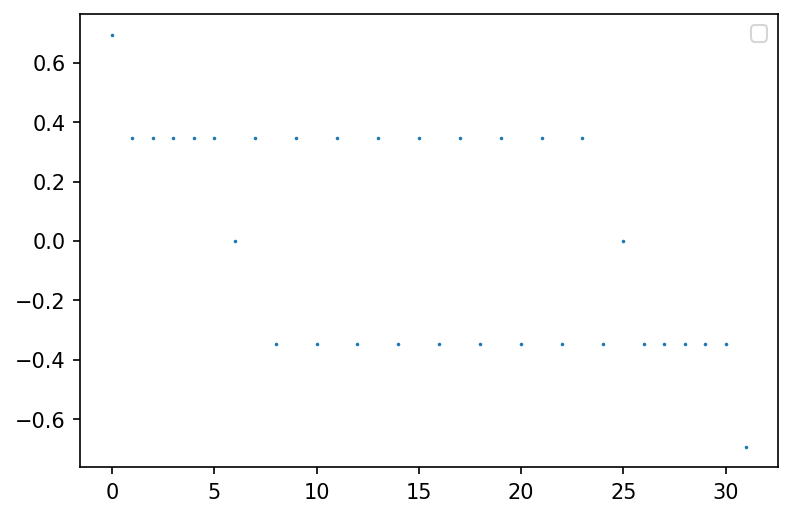

In [18]:
plt.figure(dpi = 150)
plt.scatter([i for i in range(2*strip_width)], test3, s = 0.5)
plt.legend()

In [20]:
sum(test3)

-7.107869848255177e-12